#Replicating Card and Krueger's Fast Food Minimum Wage study

In this notebook we show how we replicated the results of Card and Krueger's 1994 study on fast food chains, analyzing the effects of increasing minimum wage from from \$4.25 to \$5.05 per hour in New Jersey compared to neighboring Pennsylvania.



Paper is available at http://davidcard.berkeley.edu/papers/njmin-aer.pdf

#Phase 1: Data prep

In [ ]:
#install.packages(c("tidyverse", "knitr", "lmtest", "patchwork", "modelsummary"))

library(tidyverse)
library(dplyr)
library(knitr)
library(lmtest)
library(patchwork)
library(modelsummary)

Installing packages into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

also installing the dependencies ‘bayestestR’, ‘datawizard’, ‘zoo’, ‘checkmate’, ‘insight’, ‘parameters’, ‘performance’, ‘tables’, ‘tinytable’


── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.1     ✔ stringr   1.5.2
✔ ggplot2   4.0.0     ✔ tibble    3.3.0
✔ lubridate 1.9.4     ✔ tidyr     1.3.1
✔ purrr     1.1.0     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors
Loading required package: zoo


Attaching package: ‘zoo’


The following objects are masked from ‘package:base’:

    as.Date, as.Date.numeric




In [ ]:
tempfile_path <- tempfile()
download.file("http://davidcard.berkeley.edu/data_sets/njmin.zip", destfile = tempfile_path)
tempdir_path <- tempdir()
unzip(tempfile_path, exdir = tempdir_path)

codebook <- read_lines(file = paste0(tempdir_path, "/codebook"))

variable_names <- codebook %>%
  `[`(8:59) %>% #I select lines 8 to 59 using the `[`() function
  `[`(-c(5, 6, 13, 14, 32, 33)) %>%  #I remove lines that I do not need
  str_sub(1, 13) %>% # I only keep the first 13 characters
  # (which are the variable names, plus some white space characters)
  str_squish() %>%   #  to remove all the unneeded white space characters
  str_to_lower()  # change the column names to lowercase

#glimpse(variable_names)
#variable_names
dataset <- read_table(paste0(tempdir_path, "/public.dat"), col_names = FALSE)
dataset <- dataset %>%
  select(-X47) %>%
  `colnames<-`(., variable_names) %>%
  mutate_all(as.numeric) %>%
  mutate(sheet = as.character(sheet))
#glimpse(dataset)
#saveRDS(dataset, file = "dataset_njmin.rds")

#credits: https://www.brodrigues.co/blog/2019-05-04-diffindiff_part2/
#credits: https://github.com/alopatina/Applied-Causal-Analysis/blob/master/Difference%20in%20difference%20Min%20Wages%20and%20Employment%20Card%20and%20Krueger%20replication.ipynb

df <- as.data.frame(dataset)


── Column specification ────────────────────────────────────────────────────────
cols(
  .default = col_character(),
  X1 = col_double(),
  X2 = col_double(),
  X3 = col_double(),
  X4 = col_double(),
  X5 = col_double(),
  X6 = col_double(),
  X7 = col_double(),
  X8 = col_double(),
  X9 = col_double(),
  X10 = col_double(),
  X11 = col_double(),
  X18 = col_double(),
  X20 = col_double(),
  X21 = col_double(),
  X22 = col_double(),
  X28 = col_double(),
  X29 = col_double(),
  X30 = col_double(),
  X47 = col_logical()
)
ℹ Use `spec()` for the full column specifications.

Warning message:
“There were 28 warnings in `mutate()`.
The first warning was:
ℹ In argument: `empft = .Primitive("as.double")(empft)`.
Caused by warning:
! NAs introduced by coercion
ℹ Run `dplyr::last_dplyr_warnings()` to see the 27 remaining warnings.”


In [ ]:
data2 <- dataset %>%            #proceeding this way we can compute better models
  select(co_owned, empft, emppt, nmgrs, empft2, emppt2, nmgrs2,
         state, chain, status2, wage_st, wage_st2, northj, centralj, southj, shore, pa1, pa2) %>%
  mutate(
    state = as.character(state),
    fte_before = empft + nmgrs + emppt * 0.5,
    fte_after  = empft2 + nmgrs2 + emppt2 * 0.5,
    # dummy per le catene, più pulito
    contr_bk   = ifelse(chain == "1", 1, 0),
    contr_kfc  = ifelse(chain == "2", 1, 0),
    contr_roys = ifelse(chain == "3", 1, 0),
    contr_wend = ifelse(chain == "4", 1, 0),
    #gap variable
    gapp = ifelse(state == 1 & wage_st <= 5.05, (5.05 - wage_st) / wage_st, 0),
) %>%

 filter(complete.cases(fte_before, fte_after, wage_st, wage_st2) | status2 == 3)
# filter to keep stores with available data on employment and starting wages
# including permanently closed stores

data2$region[data2$state == 1 & data2$northj == 1]   <- "North_NJ"
data2$region[data2$state == 1 & data2$centralj == 1] <- "Central_NJ"
data2$region[data2$state == 1 & data2$southj == 1]   <- "South_NJ"
data2$region[data2$state == 1 & data2$shore == 1]    <- "Shore_NJ"

data2$region[data2$state == 0 & data2$pa1 == 1] <- "North_PA"
data2$region[data2$state == 0 & data2$pa2 == 1] <- "South_PA"

region <- factor(data2$region)

Warning message:
“Unknown or uninitialised column: `region`.”


By doing so, we can obtain and preprocess the full dataset directly from the internet, without the need to download it locally and then upload it into the notebook manually. This approach ensures that the data we use is consistent and reproducible for all users.

# Phase 2: calculations, FTE, data visual

Now we proceed with the calculation of full-time equivalents (FTE) for each restaurant. FTE is a measure that normalizes worktime.
$$\text{FTE}=\text{full time employees}+\text{managers}+0.5\times\text{part time employees}$$



In [ ]:
df$fte1 = df$empft + df$nmgrs + 0.5*df$emppt #Wave 1 (before April 1992)
df$fte2 = df$empft2 + df$nmgrs2 + 0.5*df$emppt2 #Wave 2 (after April 1992)

df$state = factor(df$state, labels = c("PA", "NJ")) #0 is PA, 1 is NJ

n_pa <- sum(df$state == "PA", na.rm = TRUE)
n_nj <- sum(df$state == "NJ", na.rm = TRUE)

#n_pa = 79
#n_nj = 331 #we can check that the numbers coincide with the data reported in Card-Krueger's paper
#we will also need this number for inference, later

df$dfte=df$fte2-df$fte1 #DELTA FTE

1.1 Compute summary statistics (mean, median, standard deviation) of FTE employment
before and after the minimum wage change, separately for NJ and PA.

For computing mean, median and standard deviation we set a function `function(arg)` that yields these statistics in a vector.

In [ ]:
summary_stats <- function(x) { c (
    mean = mean(x, na.rm = TRUE), median = median(x, na.rm = TRUE), sd = sd(x, na.rm = TRUE))}

results_1 <- tapply(df$fte1, df$state, summary_stats)
results_2 <- tapply(df$fte2, df$state, summary_stats)

results_1_df <- do.call(rbind, results_1)
results_1_df <- data.frame(State = rownames(results_1_df), results_1_df)
rownames(results_1_df) <- NULL

results_2_df <- do.call(rbind, results_2)
results_2_df <- data.frame(State = rownames(results_2_df), results_2_df)
rownames(results_2_df) <- NULL

kable(results_1_df, caption = "FTE Before Wage Increase")
kable(results_2_df, caption = "FTE After Wage Increase")




Table: FTE Before Wage Increase

|State |     mean| median|        sd|
|:-----|--------:|------:|---------:|
|PA    | 23.33117|  20.50| 11.856283|
|NJ    | 20.43941|  19.25|  9.106239|



Table: FTE After Wage Increase

|State |     mean| median|       sd|
|:-----|--------:|------:|--------:|
|PA    | 21.16558|   20.0| 8.276732|
|NJ    | 21.02743|   20.5| 9.293024|

1.2  "Use graphical displays (boxplots, histograms, barplots, to describe FTE employment
before and after the minimum wage change by state and chain".

Let's start with boxplots.
BY STATE:

Warning message:
“Removed 26 rows containing non-finite outside the scale range
(`stat_boxplot()`).”
Warning message:
“Removed 26 rows containing non-finite outside the scale range
(`stat_summary()`).”


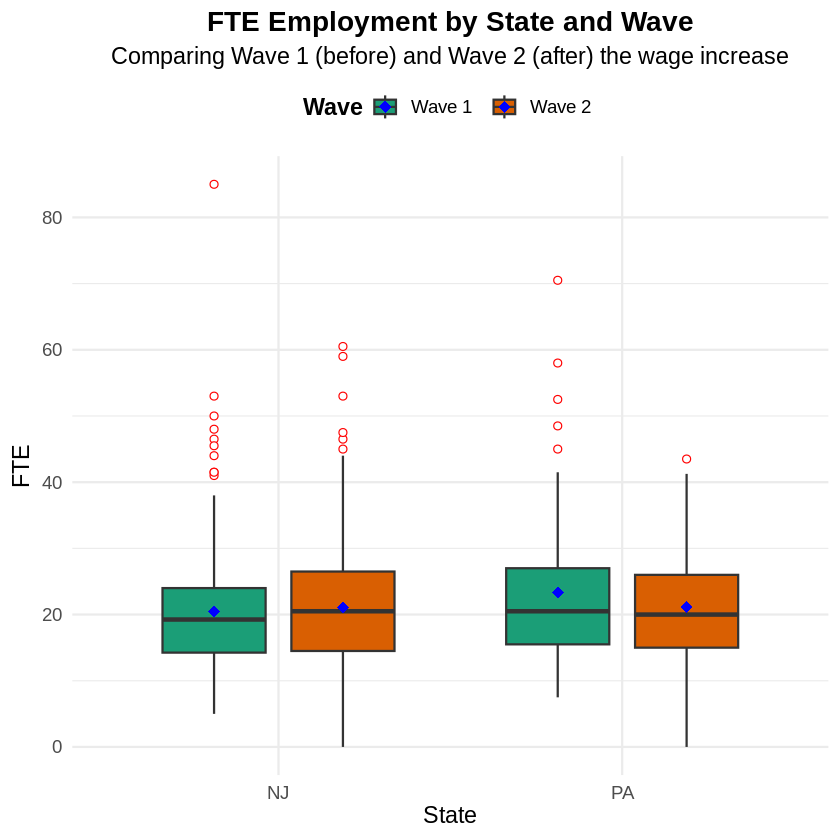

In [ ]:
#in order to use ggplot2 to make beautiful boxplots, we need to transform the dataframe from wide to long format
df_long <- df %>%
  pivot_longer(
    cols = c(fte1, fte2),
    names_to = "wave",
    values_to = "FTE"
  ) %>%
  mutate(
    wave = recode(wave, fte1 = "Wave 1", fte2 = "Wave 2"),
    state = factor(state, levels = c("NJ", "PA")),
  )

#png("boxplot_by_state.png", width=1200, height=700)
ggplot(df_long, aes(x=state, y=FTE, fill=wave)) +
  geom_boxplot(
    position = position_dodge(width=0.75), width = 0.6, outlier.shape = 21, outlier.color = "red",
    outlier.fill = "white"
  ) +
  stat_summary(
    fun = mean, #we add a dot to the boxplot, that is the mean
    geom = "point",
    shape = 18,
    size = 3,
    color = "blue",
    position = position_dodge(width=0.75)
  ) +
  scale_fill_manual(values = c("Wave 1" = "#1b9e77", "Wave 2" = "#d95f02")) +
  labs(
    title = "FTE Employment by State and Wave",
    subtitle = "Comparing Wave 1 (before) and Wave 2 (after) the wage increase",
    x = "State",
    y = "FTE",
    fill = "Wave"
  ) +
  theme_minimal(base_size = 14) +
  theme(
    plot.title = element_text(face = "bold", hjust = 0.5),
    plot.subtitle = element_text(hjust = 0.5),
    legend.position = "top",
    legend.title = element_text(face = "bold")
  )
#dev.off()

In [ ]:
png("boxplot_by_state.png", width=1200, height=700)
par(mfrow=c(1,2))
boxbst1 <- boxplot(fte1 ~ state, data=df, main="FTE - Wave 1", ylab="FTE", xlab="State", col=c("#002A86", "#FFCA66")) #colors of Pennsylvania and New Jersey flags respectively

boxbst2 <- boxplot(fte2 ~ state, data=df, main="FTE - Wave 2", ylab="FTE", xlab="State", col=c("#002A86", "#FFCA66"))
dev.off()

agg_record_1228859910 
                    2

BY CHAIN:

In [ ]:
png("boxplot_by_chain.png", width=1500, height=700)
par(mfrow =c(1, 2))
boxplot(fte1 ~ chain, data=df,
        main="FTE by chain - Wave 1",
        ylab="FTE",
        col=c("#ff8c00", "#C41230", "#F7AF2B", "#199FDA"), #main colors of chain logos respectively
        names=c("BK", "KFC", "Roy R.", "Wendys"))

boxplot(fte2 ~ chain, data=df,
        main="FTE by chain - Wave 2",
        ylab="FTE",
        col=c("#ff8c00", "#C41230", "#F7AF2B", "#199FDA"),
        names=c("BK", "KFC", "Roy R.", "Wendys"))
dev.off()

agg_record_1028270403 
                    2

BY STATE AND CHAIN:

In [ ]:
labels <- c("PA - BK", "NJ - BK", "PA - KFC", "NJ - KFC", "PA - RR", "NJ - RR", "PA - WN", "NJ - WN")

png("boxplot_by_state_and_chain.png", width=1500, height=700)
par(mfrow =c(1, 2))
boxplot(fte1 ~ state + chain, data = df,
        main = "FTE Employment - Wave 1", ylab="FTE", col = c("#ff8c00", "#ff8c00", "#C41230", "#C41230", "#F7AF2B", "#F7AF2B", "#199FDA", "#199FDA"), names = labels)

boxplot(fte2 ~ state + chain, data = df,
        main = "FTE Employment - Wave 2", ylab="FTE", col = c("#ff8c00", "#ff8c00", "#C41230", "#C41230", "#F7AF2B", "#F7AF2B", "#199FDA", "#199FDA"), names = labels)
dev.off()

agg_record_1965859979 
                    2

HISTOGRAM BY STATE:

In [ ]:
png("hist_by_state.png", width=1200, height=900)
par(mfrow = c(2, 2))
hist(df$fte1[df$state == "NJ"],
     main = "NJ - Before", xlab = "FTE", col = "#FFCA66", border = "white")  #col=c("#002A86", "#FFCA66") (COLORS OF STATE FLAGS)
hist(df$fte2[df$state == "NJ"],
     main = "NJ - After", xlab = "FTE", col = "#FFCA66", border = "white")
hist(df$fte1[df$state == "PA"],
     main = "PA - Before", xlab = "FTE", col = "#002A86", border = "white")
hist(df$fte2[df$state == "PA"],
     main = "PA - After", xlab = "FTE", col = "#002A86", border = "white")
dev.off()

agg_record_1271027707 
                    2

HISTOGRAM BY CHAIN:

In [ ]:
png("FTE histogram - BK and KFC.png", width=1700, height=1200)
par(mfrow=c(2,4))
hist(df$fte1[df$chain == 1 & df$state == "NJ"], main = "BK in NJ - Before", xlab = "FTE", col = "#ff8c00", border = "white")
hist(df$fte2[df$chain == 1 & df$state == "NJ"], main = "BK in NJ - After", xlab = "FTE", col = "#ff8c00", border = "white")
hist(df$fte1[df$chain == 2 & df$state == "NJ"], main = "KFC in NJ - Before", xlab = "FTE", col = "#a6192e", border = "white")
hist(df$fte2[df$chain == 2 & df$state == "NJ"], main = "KFC in NJ - After", xlab = "FTE", col = "#a6192e", border = "white")
hist(df$fte1[df$chain == 1 & df$state == "PA"], main = "BK in PA - Before", xlab = "FTE", col = "#d2691e", border = "white")
hist(df$fte2[df$chain == 1 & df$state == "PA"], main = "BK in PA - After", xlab = "FTE", col = "#d2691e", border = "white")
hist(df$fte1[df$chain == 2 & df$state == "PA"], main = "KFC in PA - Before", xlab = "FTE", col = "#000000", border = "white")
hist(df$fte2[df$chain == 2 & df$state == "PA"], main = "KFC in PA - After", xlab = "FTE", col = "#000000", border = "white")
dev.off()

png("FTE histogram - Roy Roger's and Wendy's.png", width=1700, height=1200)
par(mfrow=c(2,4))
hist(df$fte1[df$chain == 3 & df$state == "NJ"], main = "RR in NJ - Before", xlab = "FTE", col = "#D91E2A", border = "white")
hist(df$fte2[df$chain == 3 & df$state == "NJ"], main = "RR in NJ - After", xlab = "FTE", col = "#D91E2A", border = "white")
hist(df$fte1[df$chain == 4 & df$state == "NJ"], main = "WEN in NJ - Before", xlab = "FTE", col = "#199fda", border = "white")
hist(df$fte2[df$chain == 4 & df$state == "NJ"], main = "WEN in NJ - After", xlab = "FTE", col = "#199fda", border = "white")
hist(df$fte1[df$chain == 3 & df$state == "PA"], main = "RR in PA - Before", xlab = "FTE", col = "#F7AF2B", border = "white")
hist(df$fte2[df$chain == 3 & df$state == "PA"], main = "RR in PA - After", xlab = "FTE", col = "#F7AF2B", border = "white")
hist(df$fte1[df$chain == 4 & df$state == "PA"], main = "WEN in PA - Before", xlab = "FTE", col = "#e2203d", border = "white")
hist(df$fte2[df$chain == 4 & df$state == "PA"], main = "WEN in PA - After", xlab = "FTE", col = "#e2203d", border = "white")
dev.off()

#https://htmlcolors.com/brand-color/wendys#:~:text=Subscribe-,Wendy's%20Color,PNG%20image%20of%20Wendy's
#https://www.schemecolor.com/roy-rogers-restaurants-logo-colors.php


agg_record_2120271114 
                    2

agg_record_2120271114 
                    2

# BARPLOTS:

In [ ]:
m <- c( mean(df$fte1[df$state == "NJ"], na.rm = TRUE),
mean(df$fte2[df$state == "NJ"], na.rm = TRUE),
mean(df$fte1[df$state == "PA"], na.rm = TRUE),
mean(df$fte2[df$state == "PA"], na.rm = TRUE))

labels <- c("NJ before","NJ after", "PA before", "PA after")

m_rev <- rev(m)

labels_rev <- rev(labels)
colors_rev <- rev(c("#FFCA66", "#FFCA66", "#002A86", "#002A86")) #col=c("#002A86", "#FFCA66") (COLORS OF STATE FLAGS)

png("barplot-by-state.png", width="1000", height="700")
b <-barplot(m_rev, names.arg = labels_rev,
  horiz = TRUE,
  col = colors_rev,
  main = "Average FTE Employment Before vs After (by State)",
  xlab = "Mean FTE",
  xlim = c(0, max(m) * 1.3),
  space = c(0, 0.1, 1, 0.1))
text(m_rev, b, labels = round(m_rev, 1), pos = 4)
dev.off()

agg_record_852179076 
                   2

#Other Graphs:
- boxplot of $\Delta\text{fte}$
- scatterplot of fte before and after
- barplot of wage range (as in page 6 of Card and Krueger's paper)


Warning message:
“Removed 26 rows containing non-finite outside the scale range
(`stat_boxplot()`).”
Warning message:
“Removed 26 rows containing non-finite outside the scale range
(`stat_summary()`).”


agg_record_1319112724 
                    2

Warning message:
“Removed 26 rows containing non-finite outside the scale range
(`stat_boxplot()`).”
Warning message:
“Removed 26 rows containing non-finite outside the scale range
(`stat_summary()`).”


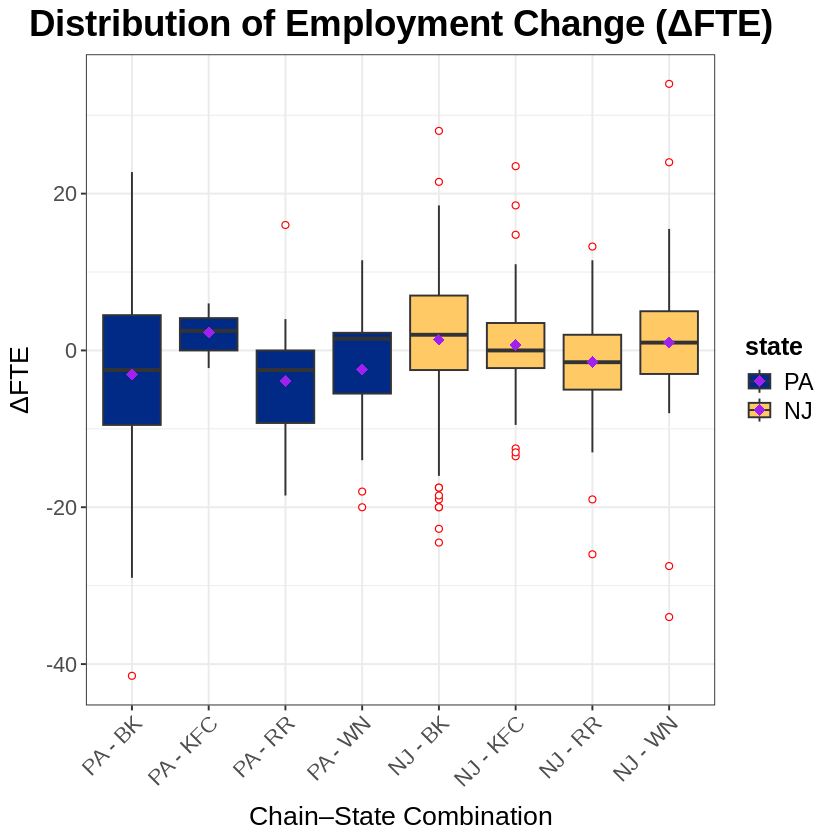

In [ ]:
labels2 <- c("PA - BK", "PA - KFC", "PA - RR", "PA - WN",
             "NJ - BK", "NJ - KFC", "NJ - RR", "NJ - WN")

png("boxplot-delta-fte.png", width = 1200, height = 800)

deltabox <- ggplot(df, aes(x = interaction(chain, state), y = dfte, fill = state)) +
  geom_boxplot(outlier.shape = 21, outlier.color = "red", outlier.fill = "white") +
  labs(
    title = "Distribution of Employment Change (ΔFTE)",
    x = "Chain–State Combination",
    y = "ΔFTE"
  ) +
  stat_summary(
    fun = mean,
    geom = "point",
    shape = 18,
    size = 3,
    color = "purple",
    position = position_dodge(width = 0.75)
  ) +
  scale_x_discrete(labels = labels2) +
  scale_fill_manual(values = c("PA" = "#002A86", "NJ" = "#FFCA66")) +
  theme_bw(base_size = 12) +
  theme(
    plot.title = element_text(size = 22, face = "bold", hjust = 0.5),
    axis.title = element_text(size = 16),
    axis.text = element_text(size = 13),
    axis.text.x = element_text(angle = 45, hjust = 1),
    legend.title = element_text(size = 15, face = "bold"),
    legend.text = element_text(size = 14)
  )

print(deltabox)
dev.off()

deltabox

agg_record_641775427 
                   2

`geom_smooth()` using formula = 'y ~ x'
Warning message:
“Removed 26 rows containing non-finite outside the scale range
(`stat_smooth()`).”
Warning message:
“Removed 26 rows containing missing values or values outside the scale range
(`geom_point()`).”


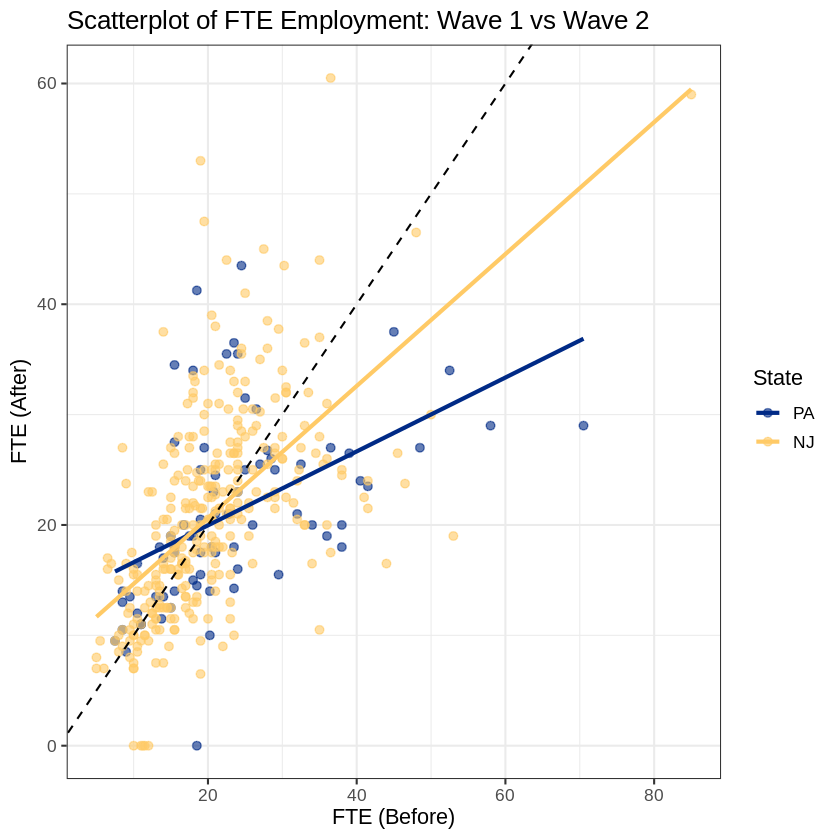

In [ ]:
png("scatterplot-fte1-vs-fte2.png", width=1000, height=900)
scatpltfte12 <- ggplot(df, aes(x = fte1, y = fte2, color = state)) +
  geom_point(alpha = 0.6, size = 2) +
  geom_smooth(method = "lm", se = FALSE, linetype = "solid") +
  geom_abline(slope = 1, intercept = 0, linetype = "dashed", color = "black") +
  labs(
    title = "Scatterplot of FTE Employment: Wave 1 vs Wave 2",
    x = "FTE (Before)",
    y = "FTE (After)",
    color = "State"
  ) +
  scale_color_manual(values = c("PA" = "#002A86", "NJ" = "#FFCA66")) +
  theme_bw(base_size = 13)
dev.off()

scatpltfte12

`geom_smooth()` using formula = 'y ~ x'
Warning message:
“Removed 26 rows containing non-finite outside the scale range
(`stat_smooth()`).”
Warning message:
“Removed 26 rows containing missing values or values outside the scale range
(`geom_point()`).”


agg_record_204874734 
                   2

`geom_smooth()` using formula = 'y ~ x'
Warning message:
“Removed 26 rows containing non-finite outside the scale range
(`stat_smooth()`).”
Warning message:
“Removed 26 rows containing missing values or values outside the scale range
(`geom_point()`).”


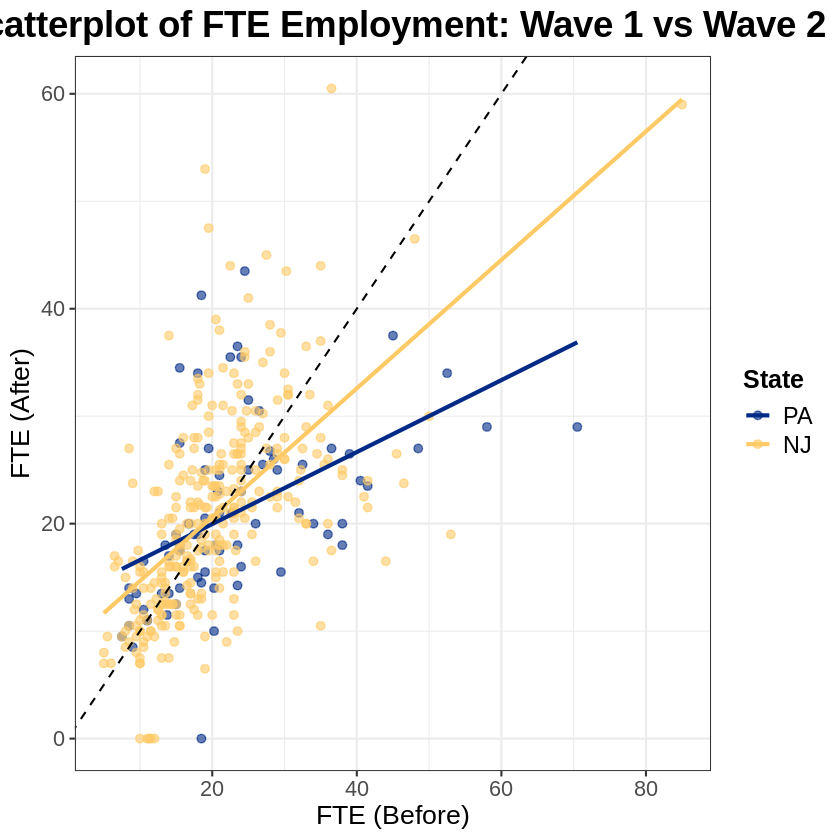

In [ ]:
png("scatterplot-fte1-vs-fte2.png", width = 1000, height = 900)

scatpltfte12 <- ggplot(df, aes(x = fte1, y = fte2, color = state)) +
  geom_point(alpha = 0.6, size = 2) +
  geom_smooth(method = "lm", se = FALSE, linetype = "solid") +
  geom_abline(slope = 1, intercept = 0, linetype = "dashed", color = "black") +
  labs(
    title = "Scatterplot of FTE Employment: Wave 1 vs Wave 2",
    x = "FTE (Before)",
    y = "FTE (After)",
    color = "State"
  ) +
  scale_color_manual(values = c("PA" = "#002A86", "NJ" = "#FFCA66")) +
  theme_bw(base_size = 13) +
  theme(
    plot.title = element_text(size = 22, face = "bold", hjust = 0.5),
    axis.title = element_text(size = 16),
    axis.text = element_text(size = 13),
    legend.text = element_text(size = 14),
    legend.title = element_text(size = 15, face = "bold")
  )

print(scatpltfte12)
dev.off()
scatpltfte12

Warning message:
“Removed 5 rows containing missing values or values outside the scale range
(`geom_bar()`).”
Warning message:
“Removed 10 rows containing missing values or values outside the scale range
(`geom_bar()`).”


agg_record_1245861368 
                    2

Warning message:
“Removed 5 rows containing missing values or values outside the scale range
(`geom_bar()`).”
Warning message:
“Removed 10 rows containing missing values or values outside the scale range
(`geom_bar()`).”


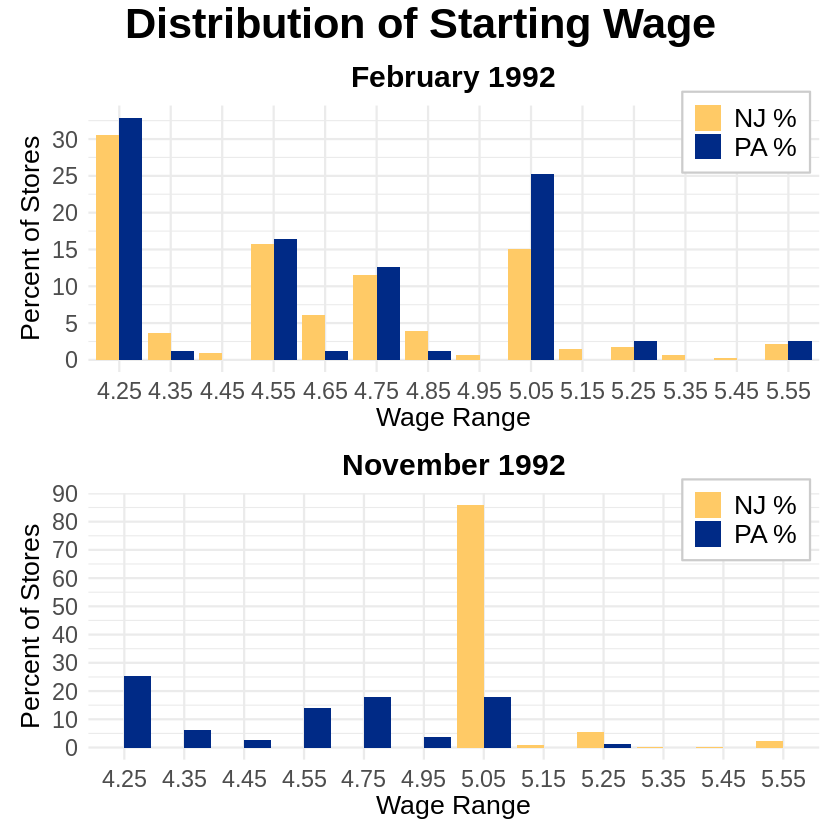

In [ ]:
#barplot of wages before and after policy
data1 <- dataset %>%
  select(co_owned, southj, centralj, northj, pa1, pa2,
         wage_st, wage_st2, hrsopen, hrsopen2,
         empft, emppt, nmgrs, empft2, emppt2, nmgrs2,
         state, chain, status2) %>%
  mutate(across(everything(), ~replace_na(., 0)),
         state = as.character(as.numeric(state)),
         fte_before = empft + nmgrs + emppt * 0.5,
         fte_after  = empft2 + nmgrs2 + emppt2 * 0.5)

table2 <- data1 %>%
  mutate(store = 1,
         category = cut(wage_st,
                        breaks = seq(4.19, 5.60, 0.1),
                        labels = seq(4.25, 5.55, 0.1))) %>%
  group_by(state, category) %>%
  summarise(sum = sum(store), .groups = "drop") %>%
  filter(!is.na(category)) %>%
  pivot_wider(names_from = state, values_from = sum)

full_table <- table2 %>%
  mutate(pa_percent = (`0` / 79) * 100,
         nj_percent = (`1` / 331) * 100) %>%
  pivot_longer(cols = c(pa_percent, nj_percent),
               names_to = "state", values_to = "percent")

table2_after <- data1 %>%
  mutate(store = 1,
         category = cut(wage_st2,
                        breaks = seq(4.19, 5.60, 0.1),
                        labels = seq(4.25, 5.55, 0.1))) %>%
  group_by(state, category) %>%
  summarise(sum = sum(store), .groups = "drop") %>%
  filter(!is.na(category)) %>%
  pivot_wider(names_from = state, values_from = sum)

full_table_after <- table2_after %>%
  mutate(pa_percent = (`0` / 79) * 100,
         nj_percent = (`1` / 331) * 100) %>%
  pivot_longer(cols = c(pa_percent, nj_percent),
               names_to = "state", values_to = "percent")

png("barplot-feb-vs-nov-1992.png", width = 1200, height = 1200)

p1 <- ggplot(full_table, aes(x = category, y = percent, fill = state)) +
  geom_bar(stat = "identity", position = "dodge") +
  ggtitle("February 1992") +
  scale_x_discrete("Wage Range") +
  scale_y_continuous("Percent of Stores", breaks = seq(0, 35, 5)) +
  scale_fill_manual(values = c("pa_percent" = "#002A86", "nj_percent" = "#FFCA66"), labels = c("NJ %", "PA %")) +
  theme_minimal(base_size = 14) +
  theme(
    plot.title = element_text(size = 18, face = "bold", hjust = 0.5),
    axis.title = element_text(size = 16),
    axis.text = element_text(size = 14),
    legend.position = c(0.9, 0.9),
    legend.text = element_text(size = 16),
    legend.title = element_blank(),
    legend.background = element_rect(fill = "white", colour = "grey80")
  )

p2 <- ggplot(full_table_after, aes(x = category, y = percent, fill = state)) +
  geom_bar(stat = "identity", position = "dodge") +
  ggtitle("November 1992") +
  scale_x_discrete("Wage Range") +
  scale_y_continuous("Percent of Stores", breaks = seq(0, 90, 10)) +
  scale_fill_manual(values = c("pa_percent" = "#002A86", "nj_percent" = "#FFCA66"), labels = c("NJ %", "PA %")) +
  theme_minimal(base_size = 14) +
  theme(
    plot.title = element_text(size = 18, face = "bold", hjust = 0.5),
    axis.title = element_text(size = 16),
    axis.text = element_text(size = 14),
    legend.position = c(0.9, 0.9),
    legend.text = element_text(size = 16),
    legend.title = element_blank(),
    legend.background = element_rect(fill = "white", colour = "grey80")
  )

combined_plot <- (p1 / p2) +
  plot_annotation(
    title = "Distribution of Starting Wage",
    theme = theme(
      plot.title = element_text(size = 26, face = "bold", hjust = 0.5)
    )
  )

print(combined_plot)
dev.off()

combined_plot


1.3 Describe the percentage price change of a FULL MEAL in price by chain and state occurred between
the two waves.

To represent the percentage change we use a barplot.

In [ ]:
df$pricefm1 <- df$psoda + df$pfry + df$pentree
df$pricefm2 <- df$psoda2 + df$pfry2 + df$pentree2

agg1 <- aggregate(pricefm1 ~ chain + state, data=df, mean, na.rm=TRUE)
agg2 <- aggregate(pricefm2 ~ chain + state, data=df, mean, na.rm=TRUE)

tab <- merge(agg1, agg2, by=c("chain","state"))
tab$perch <- 100 * (tab$pricefm2 - tab$pricefm1) / tab$pricefm1

tab

chain,state,pricefm1,pricefm2,perch
<dbl>,<fct>,<dbl>,<dbl>,<dbl>
1,NJ,2.977538,3.001855,0.8166604
1,PA,2.685625,2.672813,-0.4770770
2,NJ,4.366818,4.383846,0.3899400
2,PA,4.202500,4.145000,-1.3682332
3,NJ,3.259155,3.275067,0.4882167
3,PA,3.042353,2.971333,-2.3343645
4,NJ,3.079318,3.382683,9.8516856
4,PA,2.875333,2.920833,1.5824252


In [ ]:
tab$chain <- factor(tab$chain, levels = c("BK", "KFC", "R. ROGER'S", "WENDY'S"))
tab$state <- factor(tab$state, levels = c("NJ", "PA"))

tab$label <- factor(paste(tab$chain, tab$state, sep="-"),
                    levels = c("BK-NJ","BK-PA",
                               "KFC-NJ","KFC-PA",
                               "RR-NJ","RR-PA",
                               "WN-NJ","WN-PA"))



colors <- ifelse(tab$state == "NJ", "#FFCA66", "#002A86")

png("barplot-perch-fullmeal-by-chain-and-state.png", width=1000, height = 800)
bp <- barplot(tab$perch[order(tab$label)],
              col = colors[order(tab$label)],
              border = "white",
              ylim = c(min(tab$perch) - 1, max(tab$perch) + 1),
              ylab = "Price Change (%)",
              main = "Percentage Change in Meal Price by Chain and State", cex.main = 2, font.main = 2)

abline(h = 0, col = "black", lty = 2)

vals <- tab$perch[order(tab$label)]
text(x = bp,
     y = ifelse(vals >= 0, vals + 0.5, vals - 0.5),
     labels = round(tab$perch[order(tab$label)], 1),
     cex = 0.7, col = "black")

legend("topright",
       legend = c("NJ","PA"),
       fill = c("#FFCA66","#002A86"),
       border = "white",
       title = "State")

chain_names <- levels(tab$chain)
chain_centers <- sapply(1:4, function(i) {
  mean(bp[(2*i-1):(2*i)])
})
axis(1, at = chain_centers, labels = chain_names, tick = FALSE, line = 0, cex.axis = 0.9)
dev.off()

agg_record_2026328899 
                    2

We want to analyze wether the rise of minimum wages caused inflation on full meal prices.

We run a regression: $$\Delta \text{price}_i(\%)=\beta_0+\beta_1 I(\text{NJ}_i)+\varepsilon_i$$ so the null hypotesis is $H0:\beta_1=0$ vs $H_1:\beta_1\not=0$.

We also run a t test.

In [ ]:
reg_price <- lm(perch ~ I(state == "NJ"), data = tab)
summary(reg_price) #est 3.5359 se 2.4690  t 1.432 p 0.202

t.test(perch ~ state, data = tab, alternative = "greater") #t = 1.4322, df = 3.7622, p-value = 0.1148


Call:
lm(formula = perch ~ I(state == "NJ"), data = tab)

Residuals:
    Min      1Q  Median      3Q     Max 
-2.4967 -2.1521 -1.2020  0.6871  6.9651 

Coefficients:
                     Estimate Std. Error t value Pr(>|t|)
(Intercept)           -0.6493     1.7458  -0.372    0.723
I(state == "NJ")TRUE   3.5359     2.4690   1.432    0.202

Residual standard error: 3.492 on 6 degrees of freedom
Multiple R-squared:  0.2548,	Adjusted R-squared:  0.1306 
F-statistic: 2.051 on 1 and 6 DF,  p-value: 0.2021



	Welch Two Sample t-test

data:  perch by state
t = 1.4322, df = 3.7622, p-value = 0.1148
alternative hypothesis: true difference in means between group NJ and group PA is greater than 0
95 percent confidence interval:
 -1.824577       Inf
sample estimates:
mean in group NJ mean in group PA 
       2.8866257       -0.6493124 


Besides to the barplot, the regression and the t-test give a statistical proof that wage increase did not cause inflation on full meal prices (dummy not significative, high p value in the t test).

#Phase 3: DiD estimation and tests

2.a Compute the difference in average FTE employment in NJ before and after the policy,
and the same for PA:

$$\text{DiD}=(\bar X_1-\bar X_0)-(\bar Y_1-\bar Y_0)$$


In [ ]:
davg_nj <- mean(df$fte2[df$state=="NJ"], na.rm=TRUE) - mean(df$fte1[df$state=="NJ"], na.rm=TRUE)
davg_pa <- mean(df$fte2[df$state=="PA"], na.rm=TRUE) - mean(df$fte1[df$state=="PA"], na.rm=TRUE)

cat("The difference in average fte employment before and after the policy in NJ is:", davg_nj, "\n")
cat("The difference in average fte employment before and after the policy in PA (control group) is:", davg_pa, "\n")

did <- davg_nj - davg_pa
cat("DiD = ", did, "\n") #we got the DID

The difference in average fte employment before and after the policy in NJ is: 0.5880214 
The difference in average fte employment before and after the policy in PA (control group) is: -2.165584 
DiD =  2.753606 


We compute also the average fte increase in NJ and PA as:
$$\text{DiD}^*=\overline{X_1-X_0}-\overline{Y_1-Y_0}$$

🔥 DiD and DiD* mathematically are equivalent, but the two approaches can differ in the presence of missing values (NA). We'll see that this second method is best. 🔥

These results - we'll see - correspond to the coefficients of the regression $$\Delta \text{fte}=\beta_0+\beta_1 \times I(\text{NJ})+\varepsilon$$


In [ ]:
av_diff_nj <- mean(df$dfte[df$state=="NJ"], na.rm=TRUE)
av_diff_pa <- mean(df$dfte[df$state=="PA"], na.rm=TRUE)
diff_in_diff <- av_diff_nj-av_diff_pa

cat("The mean FTE increase in NJ is:", av_diff_nj, "\n")
cat("The mean FTE increase in PA is:", av_diff_pa, "\n")
cat("The Difference in Difference is:", diff_in_diff)

The mean FTE increase in NJ is: 0.4666667 
The mean FTE increase in PA is: -2.283333 
The Difference in Difference is: 2.75

In [ ]:
regdid1 <- lm((fte_after - fte_before) ~ state, data = data2)
summary(regdid1)


Call:
lm(formula = (fte_after - fte_before) ~ state, data = data2)

Residuals:
    Min      1Q  Median      3Q     Max 
-39.373  -3.873   0.551   4.301  27.801 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)  
(Intercept)   -2.127      1.074  -1.980   0.0484 *
state1         2.326      1.192   1.952   0.0517 .
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 8.791 on 355 degrees of freedom
Multiple R-squared:  0.01062,	Adjusted R-squared:  0.007831 
F-statistic:  3.81 on 1 and 355 DF,  p-value: 0.05174


$$\Delta \text{fte}_i=\beta_0+\beta_1\times I(\text{state }_i​=\text{NJ})+ε_i=-​\underset{\scriptsize(1.074)}{2.127}+\begin{cases}\underset{\scriptsize(1.192)}{2.326}+\varepsilon_i&\text{if the state is NJ}\\\varepsilon_i&\text{if the state is PA} \end{cases}$$

2.b "Calculate the DiD estimate of the effect of the minimum wage increase and test
the null that the effect was null versus the alternative that it led to a decrease in
employment in NJ, using a t test. Compute the p-value assuming
a **standard normal for the null distribution**. Compare the results with the t test
constructed under the **assumption that the variances are equal** and
with **those of the regression** of the change in employment on the state dummy".

---
We want to test $H_0:\mathbb E[\Delta X-\Delta Y]=0$ against $H_1: \mathbb E[\Delta X-\Delta Y]\not=0$ where $X$ denotes FTE in NJ and $Y$ the FTE in PA. $\Delta X=X_1-X_0$ where time 0 is pre-raise and time 1 is after the raise of minimum wage. That is the core of the DiD approach: testing whether the average difference in changes between the two states is zero.


To assess the effect of the minimum wage increase on FTE, we perform a triple comparison of statistical tests:

1. A standard two-sample t-test comparing the average changes in NJ and PA, both assuming unequal variances and, alternatively, assuming pooled variance.

2. The same t-statistic as in (1), but compared against a standard normal distribution to compute an approximate p-value.

3. A t-test obtained from the regression of $\Delta\text{fte}$ on the state dummy, testing the coefficient $\beta_1$. (DONE JUST ABOVE)

1. We proceed with the t-test assuming unequal variance:
$$t=\frac{\overline{\Delta X} -\overline{\Delta Y}}{\sqrt{\widehat{Var}(\hat d)}}=\frac{\overline{\Delta X} -\overline{\Delta Y}}{\sqrt{\frac{s^2_X}{n_1}+\frac{s^2_Y}{n_2}}}$$

In [ ]:
#FROM SCRATCH:

#recall: we already have n_nj and n_pa, we also already have the means of fte by state and the did itself
#recall: did <- davg_nj - davg_pa
#recall: df$dfte=df$fte2-df$fte1

delta_nj <- df %>% filter(state == "NJ") %>% pull(dfte) %>% na.omit()
delta_pa <- df %>% filter(state == "PA") %>% pull(dfte) %>% na.omit()

dindif <- mean(delta_nj)-mean(delta_pa)
var_nj <- var(delta_nj)
var_pa <- var(delta_pa)

t_welch <- dindif/ sqrt(var_nj/n_nj + var_pa/n_pa)
df_welch <- (var_nj/n_nj + var_pa/n_pa)^2 / ((var_nj/n_nj)^2/(n_nj-1) + (var_pa/n_pa)^2/(n_pa-1))
p_welch <- 2 * pt(-abs(t_welch), df=df_welch)

cat("Welch t-test:\n")
cat("t =", t_welch, "\n")
cat("df =", df_welch, "\n")
cat("p-value =", p_welch, "\n")
#Welch t-test:t = 2.104834 df = 101.7099 p-value = 0.03776974

Welch t-test:
t = 2.104834 
df = 101.7099 
p-value = 0.03776974 


In [ ]:
#VS WITH T-TEST function:

t.test(x = delta_nj, y = delta_pa,, data = df, var.equal = FALSE)
#t = 2.0487, df = 96.884, p-value = 0.0432


	Welch Two Sample t-test

data:  delta_nj and delta_pa
t = 2.0487, df = 96.884, p-value = 0.0432
alternative hypothesis: true difference in means is not equal to 0
95 percent confidence interval:
 0.08578438 5.41421562
sample estimates:
 mean of x  mean of y 
 0.4666667 -2.2833333 


To estimate the effect of the minimum wage increase on FTE employment, we calculated the DiD using two approaches: a manual calculation and R’s built-in Welch two-sample t-test.

Manual calculation:
We computed the difference in average FTE for each state and estimated DiD as $$\Delta_{NJ}-\Delta_{PA}$$

The t-statistic was calculated using the standard Welch formula, with degrees of freedom derived manually.

With the `t.test()` function in:

We supplied `x = delta_nj`, `y = delta_pa` with `var.equal = FALSE` to perform the Welch t-test.

The manual t-test and t.test() use almost the same formulas, but small differences arise due to handling of NA's and other rounding methods that differ.
As a result, the t-statistics and p-values are very close but not identical (manual: t = 2.1048, df = 101.71, p = 0.0378; t.test(): t = -2.0487, df = 96.88, p = 0.0432). These differences are negligible and do not affect the substantive interpretation of the test.

---

We also perform the t-test with the assumption of pooled variance. Supposing that variances of $X$ and $Y$ are equal, we can rewrite the variance of the DiD as: $$s^2=\frac{(n_1-1)s^2_X+(n_2-1)s^2_Y}{n_1+n_2-2}$$

$$\widehat{Var}(\hat d)=s^2\frac{n_1+n_2}{n_1n_2}$$

In this case, the t-statistic becomes: $$t=\frac{\overline{\Delta X} -\overline{\Delta Y}}{\sqrt{\widehat{Var}(\hat d)}}=\frac{\overline{\Delta X} -\overline{\Delta Y}}{\sqrt{s^2\left(\frac1n_{\tiny{NJ}}+\frac1n_{\tiny{PA}}\right)}}$$  

In [ ]:
s2_pooled <- ((n_nj - 1) * var_nj + (n_pa - 1) * var_pa) / (n_nj + n_pa - 2)
t_pooled <- dindif/ sqrt(s2_pooled * (1/n_nj + 1/n_pa))
df_pooled <- n_nj + n_pa - 2
p_pooled <- 2 * pt(-abs(t_pooled), df = df_pooled)

cat("T-test with pooled variance:\n")
cat("t =", t_pooled, "\n")
cat("df =", df_pooled, "\n")
cat("p-value =", p_pooled, "\n")  #T-test with pooled variance: t = 2.450771 df = 408 p-value = 0.01467389

T-test with pooled variance:
t = 2.450771 
df = 408 
p-value = 0.01467389 


In [ ]:
t.test(x = delta_nj,  y = delta_pa,  var.equal = TRUE)
#t = 2.3823, df = 382, p-value = 0.01769


	Two Sample t-test

data:  delta_nj and delta_pa
t = 2.3823, df = 382, p-value = 0.01769
alternative hypothesis: true difference in means is not equal to 0
95 percent confidence interval:
 0.480314 5.019686
sample estimates:
 mean of x  mean of y 
 0.4666667 -2.2833333 


We are also interested to test $H_0:\mathbb E[\Delta X-\Delta Y]=0$ against $H_1: \mathbb E[\Delta X-\Delta Y]< 0$.

In this case we're specifically testing whether the policy change in NJ caused a reduction in employment.

In [ ]:
t_less_not_pooled <- t.test(x = delta_nj, y = delta_pa, alternative = "less", var.equal = FALSE)
t_less_pooled <- t.test(x = delta_nj, y = delta_pa, alternative = "less", var.equal = TRUE)

t_less_not_pooled #t = 2.0487, df = 96.884, p-value = 0.9784
t_less_pooled #t = 2.3823, df = 382, p-value = 0.9912


	Welch Two Sample t-test

data:  delta_nj and delta_pa
t = 2.0487, df = 96.884, p-value = 0.9784
alternative hypothesis: true difference in means is less than 0
95 percent confidence interval:
     -Inf 4.979271
sample estimates:
 mean of x  mean of y 
 0.4666667 -2.2833333 



	Two Sample t-test

data:  delta_nj and delta_pa
t = 2.3823, df = 382, p-value = 0.9912
alternative hypothesis: true difference in means is less than 0
95 percent confidence interval:
     -Inf 4.653362
sample estimates:
 mean of x  mean of y 
 0.4666667 -2.2833333 


On the other hand, the t test that the DiD is bigger than zero is significative (p-value: 0.0216, SEE BELOW). Ironically we could demonstrate that the rise of minimum wage did increase occupation.

In [ ]:
t.test(x = delta_nj, y = delta_pa, alternative = "greater", var.equal = FALSE)
t.test(x = delta_nj, y = delta_pa, alternative = "greater", var.equal = TRUE)


	Welch Two Sample t-test

data:  delta_nj and delta_pa
t = 2.0487, df = 96.884, p-value = 0.0216
alternative hypothesis: true difference in means is greater than 0
95 percent confidence interval:
 0.5207289       Inf
sample estimates:
 mean of x  mean of y 
 0.4666667 -2.2833333 



	Two Sample t-test

data:  delta_nj and delta_pa
t = 2.3823, df = 382, p-value = 0.008847
alternative hypothesis: true difference in means is greater than 0
95 percent confidence interval:
 0.8466385       Inf
sample estimates:
 mean of x  mean of y 
 0.4666667 -2.2833333 


In both specifications, the null hypothesis that the DiD effect is zero cannot be rejected in favor of the alternative that the minimum wage increase reduced employment in New Jersey.

---

2. Now we test the same t-statistic as in point 1 (above), but compared against a standard normal distribution to compute an approximate p-value:

In [ ]:
#recall: t_welch <- dindif/ sqrt(var_nj/n_nj + var_pa/n_pa)
#recall: df_welch <- (var_nj/n_nj + var_pa/n_pa)^2 / ((var_nj/n_nj)^2/(n_nj-1) + (var_pa/n_pa)^2/(n_pa-1))
#recall: p_welch <- 2 * pt(-abs(t_welch), df=df_welch) #Welch t-test: t = 2.104834 df = 101.7099 p-value = 0.03789337

# p-values using t-distribution (Welch)
p_two_t    <- 2 * pt(-abs(t_welch), df = df_welch)       # two-sided
p_one_less_t <- pt(t_welch, df = df_welch)              # one-sided H1: mean_NJ - mean_PA < 0
p_one_greater_t <- 1 - pt(t_welch, df = df_welch)       # one-sided H1: mean_NJ - mean_PA > 0

# p-values using normal approximation
p_two_norm    <- 2 * (1 - pnorm(abs(t_welch)))
p_one_less_norm <- pnorm(t_welch)
p_one_greater_norm <- 1 - pnorm(t_welch)

#cat("Welch t-statistic (manual):", round(t_welch, 6), "\n")
#cat("Welch df:", round(df_welch, 4), "\n\n")
cat("Two-sided p-value (t):", signif(p_two_t,6), "\n")
cat("Two-sided p-value (normal approx):", signif(p_two_norm,6), "\n\n")
cat("One-sided p-value H1: DiD < 0 (t):", signif(p_one_less_t,6), "\n")
cat("One-sided p-value H1: DiD < 0 (normal approx):", signif(p_one_less_norm,6), "\n\n")
cat("One-sided p-value H1: DiD > 0 (t):", signif(p_one_greater_t,6), "\n")
cat("One-sided p-value H1: DiD > 0 (normal approx):", signif(p_one_greater_norm,6), "\n")

Two-sided p-value (t): 0.0377697 
Two-sided p-value (normal approx): 0.0353057 

One-sided p-value H1: DiD < 0 (t): 0.981115 
One-sided p-value H1: DiD < 0 (normal approx): 0.982347 

One-sided p-value H1: DiD > 0 (t): 0.0188849 
One-sided p-value H1: DiD > 0 (normal approx): 0.0176529 


Alternatively:

In [ ]:
cat("Welch t test, p value (t) H1:DiD < 0: ", t_less_not_pooled$p.value, "\n")
cat("Pooled t test p value (t) H1:Did < 0: ", t_less_pooled$p.value)
#and so on...

Welch t test, p value (t) H1:DiD < 0:  0.9784001 
Pooled t test p value (t) H1:Did < 0:  0.9911528

3. At last, we compare previous results with t-test obtained from the regression of  Δfte  on the state dummy, testing the coefficient  β1.

In [ ]:
summary(regdid1)


Call:
lm(formula = (fte_after - fte_before) ~ state, data = data2)

Residuals:
    Min      1Q  Median      3Q     Max 
-39.373  -3.873   0.551   4.301  27.801 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)  
(Intercept)   -2.127      1.074  -1.980   0.0484 *
state1         2.326      1.192   1.952   0.0517 .
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 8.791 on 355 degrees of freedom
Multiple R-squared:  0.01062,	Adjusted R-squared:  0.007831 
F-statistic:  3.81 on 1 and 355 DF,  p-value: 0.05174


In [ ]:
#now we summarize:
coef_reg <- summary(regdid1)$coefficients["state1", ]
df_reg <- regdid1$df.residual

results <- data.frame(
  Test = c("Welch", "Pooled", "Normal", "Regression"),
  t_value = round(c(t_welch, t_pooled, t_welch, coef_reg["t value"]), 3),
  df = round(c(df_welch, df_pooled, Inf, df_reg), 1),
  p_value = signif(c(p_welch, p_pooled, p_two_norm, coef_reg["Pr(>|t|)"]), 4)
)

kable(results, digits = 3, align = "c",
      col.names = c("Test", "t value", "df", "p-value"),
      caption = "Comparison of DiD test results under different assumptions")



Table: Comparison of DiD test results under different assumptions

|    Test    | t value |  df   | p-value |
|:----------:|:-------:|:-----:|:-------:|
|   Welch    |  2.105  | 101.7 |  0.038  |
|   Pooled   |  2.451  | 408.0 |  0.015  |
|   Normal   |  2.105  |  Inf  |  0.035  |
| Regression |  1.952  | 355.0 |  0.052  |

#2.C GAP variable and regressions of section B
"After constructing the variable GAP

```
df$gap = ifelse(df$state == ’NJ’ & df$wage_st <= 5.05,
((5.05-df$wage_st)/df$wage_st),0)
```

run the regression DiD models in section B of Card and Krueger (1994), including
**controls for chain and region**. Compare your results with their Table 4 and comment
on them."

We construct the GAP variable to measure the relative wage shortfall before the minimum wage increase.$$\text{GAP}_i=\begin{cases} \frac{5.05-\text{wage_st}_i}{\text{wage_st}_i}&\text{if store in NJ and wage_st_i​≤5.05,}\\0&\text{otherwise} \end{cases}$$

In [ ]:
th <- 5.05 #threshold is 5.05
df$gap <- with(df, ifelse(state == "NJ" & !is.na(wage_st) & wage_st <= th,(th - wage_st) / wage_st,0))


cat("Was there the GAP?")
table(df$state, df$gap > 0)
cat("\n")
cat("The cross-tabulation GAP-state confirms that the treatment only occurred in New Jersey", "\n")
cat("\n")
cat("Gap variable has distribution: \n")
summary(df$gap) #the average gap is 0.08036 that is 8% circa
cat("Gap is 8% on average with values up to 19%")

Was there the GAP?

    
     FALSE TRUE
  PA    79    0
  NJ    45  286


The cross-tabulation GAP-state confirms that the treatment only occurred in New Jersey 

Gap variable has distribution: 


   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
0.00000 0.00000 0.06316 0.08036 0.16092 0.18824 

Gap is 8% on average with values up to 19%

We can visualize GAP% as it follows:

agg_record_998508203 
                   2

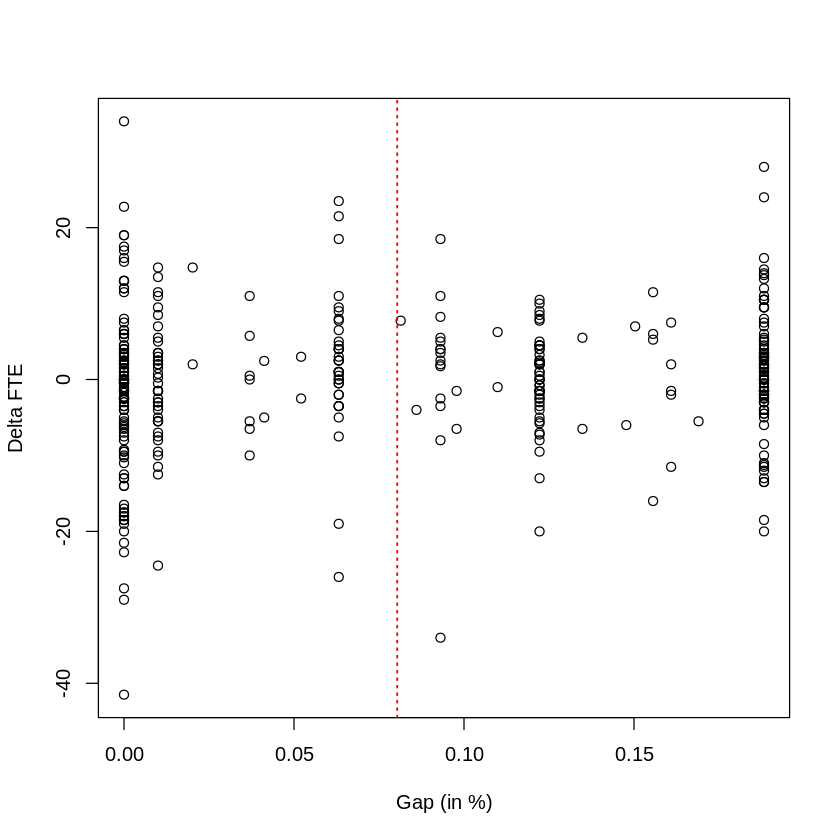

In [ ]:
plot(df$gap, df$dfte, ylab="Delta FTE", xlab="Gap (in %)")
mean_gap <- mean(df$gap, na.rm = TRUE)
abline(v = mean_gap, col = "red", lwd = 1.5, lty = 3)

png("scatterplot-gap-vs-dfte.png", width=750, height = 700)
plot(df$gap, df$dfte, ylab="Delta FTE", xlab="Gap (in %)")
mean_gap <- mean(df$gap, na.rm = TRUE)
abline(v = mean_gap, col = "red", lwd = 1.5, lty = 3)
dev.off()

#Phase 4: regression models

We aim to replicate the following table with five regression models

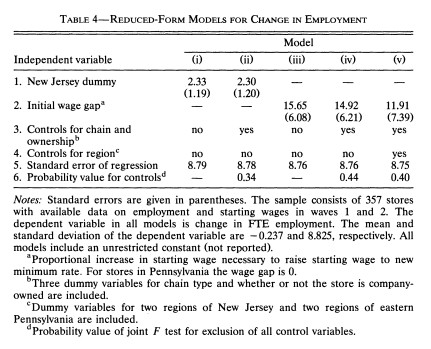

$$\begin{align}\text{Model 1: }\Delta FTE_i&=\beta_0+\beta_1 \times I(NJ)_i+\varepsilon_i \\\text{Model 2: } \Delta FTE_i&=\beta_0+\beta_1 \times I(NJ)_i+\sum_{k=1}^{K-1}\beta_{2k}\times I(CH_{k,i})+\gamma \times I(OWN)_i+\varepsilon_i \\ \text{Model 3: }\Delta FTE_i&=\beta_0+\beta_1 \times GAP_i+\varepsilon_i \\\text{Model 4: } \Delta FTE_i&=\beta_0+\beta_1 \times GAP_i+\sum_{k=1}^{K-1}\beta_{2k}\times I(CH_{k,i})+\gamma \times I(OWN)_i+\varepsilon_i \\\text{Model 5: } \Delta FTE_i&=\beta_0+\beta_1 \times GAP_i+\sum_{k=1}^{K-1}\beta_{2k}\times I(CH_{k,i})+\sum_{r=1}^{R-1}\beta_{3r}\times I(REG_{r,i})+\gamma \times I(OWN)_i+\varepsilon_i \end{align}$$

In [ ]:
regdid1 <- lm((fte_after - fte_before) ~ state, data = data2)
summary(regdid1)


Call:
lm(formula = (fte_after - fte_before) ~ state, data = data2)

Residuals:
    Min      1Q  Median      3Q     Max 
-39.373  -3.873   0.551   4.301  27.801 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)  
(Intercept)   -2.127      1.074  -1.980   0.0484 *
state1         2.326      1.192   1.952   0.0517 .
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 8.791 on 355 degrees of freedom
Multiple R-squared:  0.01062,	Adjusted R-squared:  0.007831 
F-statistic:  3.81 on 1 and 355 DF,  p-value: 0.05174


In [ ]:
regdid2 <- lm((fte_after - fte_before) ~ state + contr_bk + contr_kfc + contr_roys + co_owned, data = data2)
summary(regdid2)


Call:
lm(formula = (fte_after - fte_before) ~ state + contr_bk + contr_kfc + 
    contr_roys + co_owned, data = data2)

Residuals:
    Min      1Q  Median      3Q     Max 
-39.803  -3.903   0.606   4.106  27.393 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)  
(Intercept)   -2.209      1.613  -1.369   0.1717  
state1         2.304      1.196   1.927   0.0548 .
contr_bk       0.512      1.498   0.342   0.7328  
contr_kfc      1.004      1.686   0.595   0.5519  
contr_roys    -1.705      1.682  -1.014   0.3114  
co_owned       0.308      1.094   0.282   0.7785  
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 8.785 on 351 degrees of freedom
Multiple R-squared:  0.02315,	Adjusted R-squared:  0.009231 
F-statistic: 1.663 on 5 and 351 DF,  p-value: 0.1427


In [ ]:
regdid3 <- lm((fte_after - fte_before) ~ gapp, data = data2)
summary(regdid3)



Call:
lm(formula = (fte_after - fte_before) ~ gapp, data = data2)

Residuals:
    Min      1Q  Median      3Q     Max 
-39.924  -3.870   0.380   4.588  26.630 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)  
(Intercept)  -1.5764     0.6966  -2.263   0.0242 *
gapp         15.6529     6.0802   2.574   0.0104 *
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 8.757 on 355 degrees of freedom
Multiple R-squared:  0.01833,	Adjusted R-squared:  0.01556 
F-statistic: 6.627 on 1 and 355 DF,  p-value: 0.01045


In [ ]:
regdid4 <- lm((fte_after - fte_before) ~ gapp + contr_bk + contr_kfc +
    contr_roys + co_owned, data = data2)

summary(regdid4)


Call:
lm(formula = (fte_after - fte_before) ~ gapp + contr_bk + contr_kfc + 
    contr_roys + co_owned, data = data2)

Residuals:
    Min      1Q  Median      3Q     Max 
-40.185  -4.152   0.268   4.373  26.507 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)  
(Intercept) -1.30141    1.37389  -0.947   0.3442  
gapp        14.91567    6.20533   2.404   0.0167 *
contr_bk    -0.01362    1.51518  -0.009   0.9928  
contr_kfc    0.64534    1.69594   0.381   0.7038  
contr_roys  -1.92582    1.68287  -1.144   0.2532  
co_owned     0.40891    1.09233   0.374   0.7084  
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 8.759 on 351 degrees of freedom
Multiple R-squared:  0.0288,	Adjusted R-squared:  0.01496 
F-statistic: 2.082 on 5 and 351 DF,  p-value: 0.06717


In [ ]:
regdid5 <- lm((fte_after - fte_before) ~ gapp + contr_bk + contr_kfc +
    contr_roys + co_owned + region, data = data2)

summary(regdid5)


Call:
lm(formula = (fte_after - fte_before) ~ gapp + contr_bk + contr_kfc + 
    contr_roys + co_owned + region, data = data2)

Residuals:
    Min      1Q  Median      3Q     Max 
-41.247  -4.055   0.470   4.184  26.373 

Coefficients:
               Estimate Std. Error t value Pr(>|t|)
(Intercept)    -0.29268    1.92514  -0.152    0.879
gapp           11.95220    7.45590   1.603    0.110
contr_bk       -0.40183    1.53404  -0.262    0.794
contr_kfc       0.34249    1.71462   0.200    0.842
contr_roys     -2.60696    1.72487  -1.511    0.132
co_owned        0.27383    1.11650   0.245    0.806
regionNorth_NJ  0.22991    1.50363   0.153    0.879
regionNorth_PA -3.44055    2.27539  -1.512    0.131
regionShore_NJ -2.27062    2.04790  -1.109    0.268
regionSouth_NJ  0.07161    1.71418   0.042    0.967
regionSouth_PA  0.44139    2.07203   0.213    0.831

Residual standard error: 8.751 on 346 degrees of freedom
Multiple R-squared:  0.04445,	Adjusted R-squared:  0.01683 
F-statistic:  1.61 on

In [ ]:
list_of_models <- list(
  "(i)" = regdid1,
  "(ii)" = regdid2,
  "(iii)" = regdid3,
  "(iv)" = regdid4,
  "(v)" = regdid5
)

controls_chain <- c("no", "yes", "no", "yes", "yes")
controls_region <- c("no", "no", "no", "no", "yes")

se_reg_values <- sapply(list_of_models, sigma)
se_reg_values_fmt <- sprintf("%.2f", se_reg_values)

cm <- c(    'state1' = '1. New Jersey dummy',
    'gapp' = '2. Initial wage gap')

righe_personalizzate <- data.frame(
  term = c(
    "3. Controls for chain and ownership",
    "4. Controls for region",
    "5. Standard error of regression"),
  `(i)` = I(c(controls_chain[1], controls_region[1], se_reg_values_fmt[1])),
  `(ii)` = I(c(controls_chain[2], controls_region[2], se_reg_values_fmt[2])),
  `(iii)` = I(c(controls_chain[3], controls_region[3], se_reg_values_fmt[3])),
  `(iv)` = I(c(controls_chain[4], controls_region[4], se_reg_values_fmt[4])),
  `(v)` = I(c(controls_chain[5], controls_region[5], se_reg_values_fmt[5])),
  check.names = FALSE)

tabella_finale <- modelsummary(list_of_models, stars = FALSE, fmt = '%.2f', coef_map = cm, estimate = "{estimate}", statistic = "({std.error})", gof_omit = ".*", add_rows = righe_personalizzate, output = "tinytable")

print(tabella_finale)


+-------------------------------------+--------+--------+--------+--------+--------+
|                                     | (i)    | (ii)   | (iii)  | (iv)   | (v)    |
+=====================================+========+========+========+========+========+
| 1. New Jersey dummy                 | 2.33   | 2.30   |        |        |        |
+-------------------------------------+--------+--------+--------+--------+--------+
|                                     | (1.19) | (1.20) |        |        |        |
+-------------------------------------+--------+--------+--------+--------+--------+
| 2. Initial wage gap                 |        |        | 15.65  | 14.92  | 11.95  |
+-------------------------------------+--------+--------+--------+--------+--------+
|                                     |        |        | (6.08) | (6.21) | (7.46) |
+-------------------------------------+--------+--------+--------+--------+--------+
| 3. Controls for chain and ownership | no     | yes    | no    

In [ ]:
install.packages("gt")
library(gt)

tabella_finale <- modelsummary(list_of_models, stars = FALSE, fmt = '%.2f', coef_map = cm, estimate = "{estimate}", statistic = "({std.error})", gof_omit = ".*", add_rows = righe_personalizzate, output = "gt")

print(tabella_finale)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

also installing the dependencies ‘V8’, ‘litedown’, ‘reactR’, ‘bigD’, ‘bitops’, ‘juicyjuice’, ‘markdown’, ‘reactable’




<div id="xyfeumjcin" style="padding-left:0px;padding-right:0px;padding-top:10px;padding-bottom:10px;overflow-x:auto;overflow-y:auto;width:auto;height:auto;">
  <style>#xyfeumjcin table {
  font-family: system-ui, 'Segoe UI', Roboto, Helvetica, Arial, sans-serif, 'Apple Color Emoji', 'Segoe UI Emoji', 'Segoe UI Symbol', 'Noto Color Emoji';
  -webkit-font-smoothing: antialiased;
  -moz-osx-font-smoothing: grayscale;
}

#xyfeumjcin thead, #xyfeumjcin tbody, #xyfeumjcin tfoot, #xyfeumjcin tr, #xyfeumjcin td, #xyfeumjcin th {
  border-style: none;
}

#xyfeumjcin p {
  margin: 0;
  padding: 0;
}

#xyfeumjcin .gt_table {
  display: table;
  border-collapse: collapse;
  line-height: normal;
  margin-left: auto;
  margin-right: auto;
  color: #333333;
  font-size: 16px;
  font-weight: normal;
  font-style: normal;
  background-color: #FFFFFF;
  width: auto;
  border-top-style: solid;
  border-top-width: 2px;
  border-top-color: #A8A8A8;
  border-right-style: none;
  border-right-width: 2px;
  b

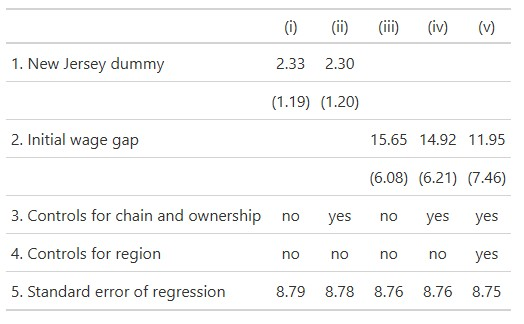

In [ ]:
install.packages("kableExtra") #FOR THE HTML VERSION (you put the output in an HTML compiler and you'll have the table)
library(kableExtra)

tabella_finale_html <- modelsummary(list_of_models, stars = FALSE, fmt = '%.2f', coef_map = cm, estimate = "{estimate}", statistic = "({std.error})", gof_omit = ".*", add_rows = righe_personalizzate, output = "kableExtra")

print(tabella_finale_html)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

also installing the dependency ‘svglite’



Attaching package: ‘kableExtra’


The following object is masked from ‘package:dplyr’:

    group_rows




<table class="table" style="width: auto !important; margin-left: auto; margin-right: auto;">
 <thead>
  <tr>
   <th style="text-align:left;">   </th>
   <th style="text-align:center;"> (i) </th>
   <th style="text-align:center;"> (ii) </th>
   <th style="text-align:center;"> (iii) </th>
   <th style="text-align:center;"> (iv) </th>
   <th style="text-align:center;"> (v) </th>
  </tr>
 </thead>
<tbody>
  <tr>
   <td style="text-align:left;"> 1. New Jersey dummy </td>
   <td style="text-align:center;"> 2.33 </td>
   <td style="text-align:center;"> 2.30 </td>
   <td style="text-align:center;">  </td>
   <td style="text-align:center;">  </td>
   <td style="text-align:center;">  </td>
  </tr>
  <tr>
   <td style="text-align:left;">  </td>
   <td style="text-align:center;"> (1.19) </td>
   <td style="text-align:center;"> (1.20) </td>
   <td style="text-align:center;">  </td>
   <td style="text-align:center;">  </td>
   <td style="text-align:center;">  </td>
  </tr>
  <tr>
   <td style="text-

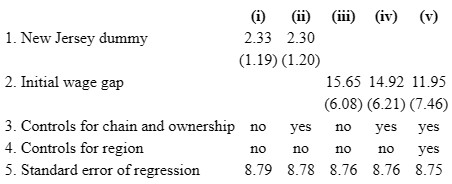

#PHASE 5: last regression (optional)

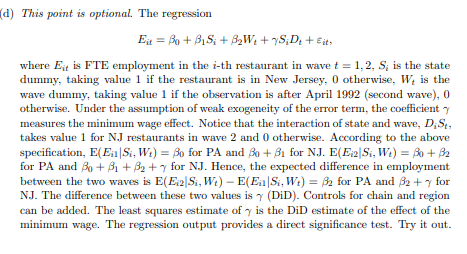

$$E_{it}=\beta_0+\beta_1S_i+\beta_2W_t+\gamma(S_i\cdot D_t)+\varepsilon_{it}$$

In [ ]:
data_did <- data.frame(
  fte = c(data2$fte_before, data2$fte_after),
  state = rep(data2$state, 2),
  wave = c(rep(0, nrow(data2)), rep(1, nrow(data2))))

In [ ]:
model_did <- lm(fte ~ state + wave + state * wave, data = data_did)
summary(model_did)


Call:
lm(formula = fte ~ state + wave + state * wave, data = data_did)

Residuals:
    Min      1Q  Median      3Q     Max 
-21.500  -6.514  -1.014   4.715  64.486 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept)   23.627      1.159  20.387   <2e-16 ***
state1        -3.113      1.286  -2.421   0.0157 *  
wave          -2.127      1.639  -1.298   0.1948    
state1:wave    2.326      1.818   1.279   0.2013    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 9.486 on 710 degrees of freedom
Multiple R-squared:  0.008861,	Adjusted R-squared:  0.004673 
F-statistic: 2.116 on 3 and 710 DF,  p-value: 0.09687
